<a href="https://colab.research.google.com/github/kkashleva/hometasks/blob/main/%D0%94%D0%97_%E2%84%969.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Использование предобученных трансформеров

**Задание 1 (8 баллов).**

Дообучите 3 предобученных модели на тех же данных, что и в семинаре. Сравните качество и выберите лучшую. Модели должны отличаться друг от друга не только параметрами ru/en/multilingual, base/large, cased/uncased. Все три выбранные модели должны работать лучше, чем бейзлайн без дообучения (т.е. если модель не работает, попробуйте другую).

In [4]:
!pip install sklearn pandas matplotlib transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 33.9 MB/s 
     |████████████████████████████████| 6.6 MB 58.2 MB/s 
     |████████████████████████████████| 84 kB 3.5 MB/s 
     |████████████████████████████████| 596 kB 63.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [5]:
# стандартные библиотеки
import os, re
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter
from string import punctuation
import matplotlib.pyplot as plt
%matplotlib inline


# tf и huggingface 
import tensorflow as tf
from transformers import TFAutoModel
from transformers import AutoTokenizer


Возьмем данные lenta.ru, но не целиком. Fine-tuning больших моделей лучше всего подходит, когда данных совсем мало и стандартным алгоритмам просто не хватает информации, чтобы обучиться. Поэтому возьмем только небольшой процент всех данных.

In [6]:
import logging
import shutil 
from google.colab import drive

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)
logger.info('Инициализировали логгер')

ROOT_DIR = '/content/drive' 
drive.mount(ROOT_DIR)
logger.info('Подключили диск')

root_data_dir = os.path.join(ROOT_DIR, 'MyDrive')
if not os.path.exists(root_data_dir):
  raise RuntimeError('Отсутствует директория с данными')

2022-05-23 19:10:37,941 : INFO : Инициализировали логгер
2022-05-23 19:10:59,959 : INFO : Подключили диск


Mounted at /content/drive


In [7]:
data = pd.read_csv(os.path.join(root_data_dir,'lenta_sample.csv'))
data.dropna(subset=['topic', 'text'], inplace=True)

In [8]:
data.topic.value_counts()

Из жизни             55
Наука и техника      54
Бывший СССР          54
Культура             53
Ценности             45
Дом                  45
Бизнес               44
Интернет и СМИ       44
Силовые структуры    40
Спорт                39
Россия               32
Экономика            32
Мир                  27
69-я параллель       13
Легпром              13
Библиотека           10
Крым                  7
Name: topic, dtype: int64

In [9]:
data.shape

(607, 6)

### Загружаем предобученную модель из huggingface transformers

In [10]:
tokenizer_roberta = AutoTokenizer.from_pretrained('roberta-base')


Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [11]:
# переводим тексты в последовательности индексов

X = []

for text in data.title:
    ids = tokenizer_roberta.encode(text)
    
    X.append(ids[:512])

In [12]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

In [13]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])


In [14]:
X.shape

(607, 512)

В этот раз добавим стратификацию, т.к. в данных у нас дисбаланс классов.

In [15]:
train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)

In [16]:
X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

#### Дообучение без замораживания предобученной модели

In [20]:
model_roberta = TFAutoModel.from_pretrained('roberta-base', trainable=True)

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [21]:
input_word_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32,
                                     name="input_ids")

output = model_roberta({"input_ids":input_word_ids})
drop = tf.keras.layers.Dropout(0.3)(output[0][:, 0]) 
dense = tf.keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_clf = tf.keras.Model(inputs=input_word_ids, outputs=dense)


model_clf.compile(tf.optimizers.Adam(learning_rate=2e-6,
                                    ), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy', 
                           tf.keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])

In [22]:
model_clf.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2,
         epochs=20)

Epoch 1/20


2022-05-23 19:17:43,115 : WARNING : Gradients do not exist for variables ['tf_roberta_model_1/roberta/pooler/dense/kernel:0', 'tf_roberta_model_1/roberta/pooler/dense/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss`argument?


2022-05-23 19:17:47,281 : WARNING : Gradients do not exist for variables ['tf_roberta_model_1/roberta/pooler/dense/kernel:0', 'tf_roberta_model_1/roberta/pooler/dense/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss`argument?


288/288 [==============================] - 99s 305ms/step - loss: 2.9492 - accuracy: 0.0781 - rec_prec: 0.0000e+00 - val_loss: 2.7392 - val_accuracy: 0.0323 - val_rec_prec: 0.0000e+00
Epoch 2/20
288/288 [==============================] - 84s 292ms/step - loss: 2.8461 - accuracy: 0.0694 - rec_prec: 0.0000e+00 - val_loss: 2.7498 - val_accuracy: 0.0645 - val_rec_prec: 0.0000e+00
Epoch 3/20
288/288 [==============================] - 84s 292ms/step - loss: 2.8514 - accuracy: 0.0816 - rec_prec: 0.0000e+00 - val_loss: 2.7423 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 4/20
288/288 [==============================] - 84s 292ms/step - loss: 2.7887 - accuracy: 0.0955 - rec_prec: 0.0000e+00 - val_loss: 2.7168 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 5/20
288/288 [==============================] - 84s 292ms/step - loss: 2.8215 - accuracy: 0.0747 - rec_prec: 0.0000e+00 - val_loss: 2.7120 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 6/20
288/288 [================

dict_keys(['loss', 'accuracy', 'rec_prec', 'val_loss', 'val_accuracy', 'val_rec_prec'])


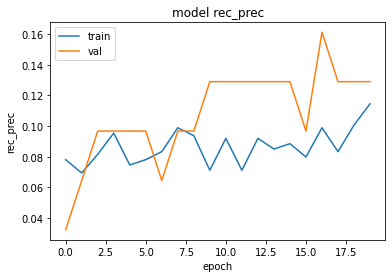

In [23]:
print(model_clf.history.history.keys())
plt.plot(model_clf.history.history['accuracy'])
plt.plot(model_clf.history.history['val_accuracy'])
plt.title('model rec_prec')
plt.ylabel('rec_prec')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [24]:
from sklearn.metrics import classification_report

In [25]:
pred = model_clf.predict(X_valid, batch_size=5).argmax(1)

In [26]:
print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

                   precision    recall  f1-score   support

  Наука и техника       0.00      0.00      0.00         3
         Культура       0.00      0.00      0.00         3
   Интернет и СМИ       0.00      0.00      0.00         2
         Из жизни       0.17      0.33      0.22         3
           Россия       0.00      0.00      0.00         2
         Ценности       0.20      0.50      0.29         2
            Спорт       0.00      0.00      0.00         2
             Крым       0.00      0.00      0.00         0
              Мир       0.00      0.00      0.00         1
              Дом       0.00      0.00      0.00         2
   69-я параллель       0.00      0.00      0.00         1
Силовые структуры       0.11      1.00      0.20         2
          Легпром       0.00      0.00      0.00         1
        Экономика       0.00      0.00      0.00         2
       Библиотека       0.00      0.00      0.00         0
           Бизнес       0.00      0.00      0.00       

In [28]:
tokenizer_albert = AutoTokenizer.from_pretrained('albert-base-v2')
model_albert = TFAutoModel.from_pretrained('albert-base-v2', trainable=True)

Some layers from the model checkpoint at albert-base-v2 were not used when initializing TFAlbertModel: ['predictions']
- This IS expected if you are initializing TFAlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFAlbertModel were initialized from the model checkpoint at albert-base-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


In [29]:
X = []

for text in data.title:
    ids = tokenizer_albert.encode(text)
    
    X.append(ids[:512])

In [30]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

In [31]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [32]:
train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)

In [33]:
X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

In [34]:
input_word_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32,
                                     name="input_ids")

output = model_albert({"input_ids":input_word_ids})
drop = tf.keras.layers.Dropout(0.3)(output[0][:, 0]) 
dense = tf.keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_clf = tf.keras.Model(inputs=input_word_ids, outputs=dense)


model_clf.compile(tf.optimizers.Adam(learning_rate=2e-6,
                                    ), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy', 
                           tf.keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])

In [35]:
model_clf.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2,
         epochs=20)

Epoch 1/20


2022-05-23 19:50:33,234 : WARNING : Gradients do not exist for variables ['tf_albert_model_1/albert/pooler/kernel:0', 'tf_albert_model_1/albert/pooler/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss`argument?


2022-05-23 19:50:36,094 : WARNING : Gradients do not exist for variables ['tf_albert_model_1/albert/pooler/kernel:0', 'tf_albert_model_1/albert/pooler/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss`argument?


288/288 [==============================] - 83s 264ms/step - loss: 3.5262 - accuracy: 0.0677 - rec_prec: 0.0000e+00 - val_loss: 2.7194 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 2/20
288/288 [==============================] - 73s 252ms/step - loss: 3.0827 - accuracy: 0.0608 - rec_prec: 0.0000e+00 - val_loss: 2.7266 - val_accuracy: 0.0645 - val_rec_prec: 0.0000e+00
Epoch 3/20
288/288 [==============================] - 72s 251ms/step - loss: 2.9903 - accuracy: 0.0712 - rec_prec: 0.0000e+00 - val_loss: 2.7050 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 4/20
288/288 [==============================] - 72s 250ms/step - loss: 2.9292 - accuracy: 0.0816 - rec_prec: 0.0000e+00 - val_loss: 2.7133 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 5/20
288/288 [==============================] - 72s 250ms/step - loss: 2.9053 - accuracy: 0.0625 - rec_prec: 0.0000e+00 - val_loss: 2.6967 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 6/20
288/288 [================

dict_keys(['loss', 'accuracy', 'rec_prec', 'val_loss', 'val_accuracy', 'val_rec_prec'])


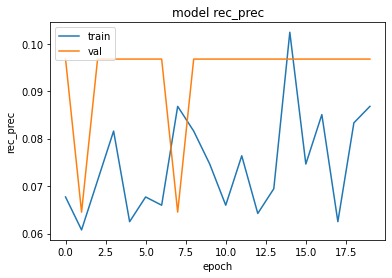

In [36]:
print(model_clf.history.history.keys())
plt.plot(model_clf.history.history['accuracy'])
plt.plot(model_clf.history.history['val_accuracy'])
plt.title('model rec_prec')
plt.ylabel('rec_prec')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [37]:
pred = model_clf.predict(X_valid, batch_size=5).argmax(1)

In [38]:
print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

                   precision    recall  f1-score   support

  Наука и техника       0.00      0.00      0.00         3
         Культура       0.10      1.00      0.18         3
   Интернет и СМИ       0.00      0.00      0.00         2
         Из жизни       0.00      0.00      0.00         3
           Россия       0.00      0.00      0.00         2
         Ценности       0.00      0.00      0.00         2
            Спорт       0.00      0.00      0.00         2
             Крым       0.00      0.00      0.00         0
              Мир       0.00      0.00      0.00         1
              Дом       0.00      0.00      0.00         2
   69-я параллель       0.00      0.00      0.00         1
Силовые структуры       0.00      0.00      0.00         2
          Легпром       0.00      0.00      0.00         1
        Экономика       0.00      0.00      0.00         2
       Библиотека       0.00      0.00      0.00         0
           Бизнес       0.00      0.00      0.00       

In [40]:
tokenizer_bert = AutoTokenizer.from_pretrained('bert-base-multilingual-uncased')
model_bert = TFAutoModel.from_pretrained('bert-base-multilingual-uncased', trainable=True)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.64M [00:48<?, ?B/s]

Downloading:   0%|          | 0.00/953M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-multilingual-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [41]:
X = []

for text in data.title:
    ids = tokenizer_bert.encode(text)
    
    X.append(ids[:512])

In [42]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

In [43]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [44]:
train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)

In [45]:
X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

In [46]:
input_word_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32,
                                     name="input_ids")

output = model_bert({"input_ids":input_word_ids})
drop = tf.keras.layers.Dropout(0.3)(output[0][:, 0]) 
dense = tf.keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_clf = tf.keras.Model(inputs=input_word_ids, outputs=dense)


model_clf.compile(tf.optimizers.Adam(learning_rate=2e-6,
                                    ), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy', 
                           tf.keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])

In [47]:
model_clf.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2,
         epochs=20)

Epoch 1/20


2022-05-23 20:18:33,729 : WARNING : Gradients do not exist for variables ['tf_bert_model/bert/pooler/dense/kernel:0', 'tf_bert_model/bert/pooler/dense/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss`argument?


2022-05-23 20:18:38,789 : WARNING : Gradients do not exist for variables ['tf_bert_model/bert/pooler/dense/kernel:0', 'tf_bert_model/bert/pooler/dense/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss`argument?


288/288 [==============================] - 106s 325ms/step - loss: 2.8651 - accuracy: 0.0868 - rec_prec: 0.0000e+00 - val_loss: 2.7544 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 2/20
288/288 [==============================] - 89s 311ms/step - loss: 2.7711 - accuracy: 0.0851 - rec_prec: 0.0000e+00 - val_loss: 2.7364 - val_accuracy: 0.0323 - val_rec_prec: 0.0000e+00
Epoch 3/20
288/288 [==============================] - 89s 310ms/step - loss: 2.7760 - accuracy: 0.0712 - rec_prec: 0.0000e+00 - val_loss: 2.7084 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 4/20
288/288 [==============================] - 89s 310ms/step - loss: 2.7524 - accuracy: 0.0903 - rec_prec: 0.0000e+00 - val_loss: 2.7143 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 5/20
288/288 [==============================] - 89s 310ms/step - loss: 2.7528 - accuracy: 0.0851 - rec_prec: 0.0000e+00 - val_loss: 2.7131 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 6/20
288/288 [===============

dict_keys(['loss', 'accuracy', 'rec_prec', 'val_loss', 'val_accuracy', 'val_rec_prec'])


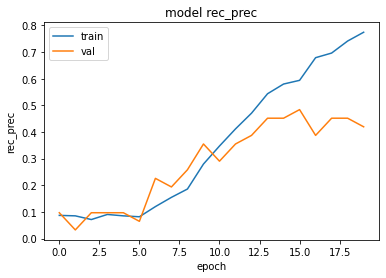

In [48]:
print(model_clf.history.history.keys())
plt.plot(model_clf.history.history['accuracy'])
plt.plot(model_clf.history.history['val_accuracy'])
plt.title('model rec_prec')
plt.ylabel('rec_prec')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [49]:
pred = model_clf.predict(X_valid, batch_size=5).argmax(1)

In [50]:
print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

                   precision    recall  f1-score   support

  Наука и техника       0.60      1.00      0.75         3
         Культура       0.00      0.00      0.00         3
   Интернет и СМИ       1.00      0.50      0.67         2
         Из жизни       0.00      0.00      0.00         3
           Россия       1.00      0.50      0.67         2
         Ценности       0.50      0.50      0.50         2
            Спорт       0.40      1.00      0.57         2
             Крым       0.00      0.00      0.00         0
              Мир       0.00      0.00      0.00         1
              Дом       1.00      0.50      0.67         2
   69-я параллель       0.00      0.00      0.00         1
Силовые структуры       0.20      0.50      0.29         2
          Легпром       0.00      0.00      0.00         1
        Экономика       0.00      0.00      0.00         2
       Библиотека       0.00      0.00      0.00         0
           Бизнес       0.17      0.50      0.25       

У BERT получились самые лучшие результаты.

**Задание 2 (2 балла)**

 *Ответьте на следующие вопросы (напишите хотя бы по несколько предложений):*

*1) Чем ROBERTA отличается от BERT? В какой статье описана ROBERTA?*

*2) Чем модель T5 отличается от ROBERTA/BERT?*

1) Модель ROBERTA описана в (Liu, Yinhan, et al. "Roberta: A robustly optimized bert pretraining approach." arXiv preprint arXiv:1907.11692 (2019)). Авторы предложили следующие улучшения для обучения BERT: 
1) обучать модель дольше, на большем количестве данных и с бОльшими батчами;
2) убрать функцию предсказания следующего предложения; 
3) обучать модель на более длинных последовательностях;
4) динамически менять маскирующий паттерн для обучающей выборки.

2) Модель T5 «понимает» и генерирует текст (название расшифровывается как Text-to-Text Transfer Transformer). Главное отличие от BERT в том, что T5 работает в формате text-to-text, тогда как BERT дает на выходе метку класса или фрагмент входной последовательности. 
